In [2]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # shape (n_samples, 1)

# Train/test split 75:25 with random seed 433
torch.manual_seed(433)
dataset = TensorDataset(X, y)
n_train = int(len(dataset) * 0.75)
n_test = len(dataset) - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_dataset[:][0].numpy())
X_test = scaler.transform(test_dataset[:][0].numpy())

# Convert back to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = train_dataset[:][1]
y_test = test_dataset[:][1]

# Wrap in TensorDataset for DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Example: check shapes
print(X_train.shape, y_train.shape)

Train samples: 15480, Test samples: 5160
torch.Size([15480, 8]) torch.Size([15480, 1])


In [4]:
# Define regression neural network
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32, 16]):
        super(RegressionNN, self).__init__()
        layers = []
        last_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(last_size, h))
            layers.append(nn.ReLU())
            last_size = h
        layers.append(nn.Linear(last_size, 1))  # Output: single value
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Instantiate model
input_size = X_train.shape[1]
model = RegressionNN(input_size).to(device)
print(model)

RegressionNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


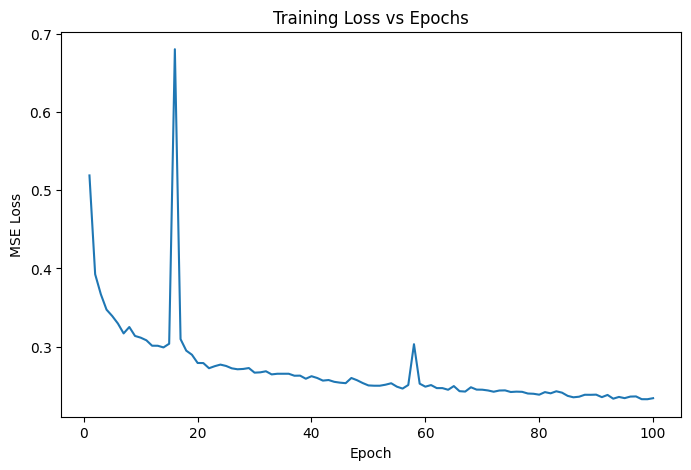

In [5]:
batch_size = 32
epochs = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

all_losses = []

model.train()
for epoch in range(epochs):
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    all_losses.append(np.mean(batch_losses))

# Plot loss vs epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), all_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss vs Epochs")
plt.show()
